In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# user defined parameters
u = 2   # velocity
Tf = 2  # final time
ax = -1; 
bx = 1
sigma = 1/8
#qinit = lambda x: np.exp(-(x/(2*sigma))**2)
qinit = lambda x : sin(2*pi*x)

def bc(t):
    return qinit(ax-u*t), qinit(bx-u*t)
    

# function f(q(x,t)) = u*q(x,t)

f = lambda q: u*q
a = 0.1

In [3]:
N = 1 # order of the legendre polynomial
Q = N+1
Ne = 100
Np = Ne*(N+1)
a = 0.1  # CFL number

In [4]:
def Lobatto_deriv(Q, x):
    F = [] # array containing the polynomials
    dF = []
    ddF = []


    f0 = 1; F.append(f0)  # first polynomial
    df0 = 0; dF.append(df0)
    f1 = x; F.append(f1)  # second polynomial
    df1 = 1; dF.append(df1)
    ddF = [0,0]

    B = []
    dB = []


    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*F[i-1] - ((i-1)/i)*F[i-2]  # iteration of the polynomials
        dfi = i*F[i-1] + x*dF[i-1]                    # first derivative
        F.append(fi)
        dF.append(dfi)
        ddfi = (i+1.0)*dF[i-1] + x*ddF[i-1]           # second derivative
        ddF.append(ddfi)

        bi = (1.0-x**2)*dF[i-1]                       # lobatto polynomial
        dbi = -2.0*x*dF[i-1] + (1.0-x**2)*ddF[i-1]    # derivative of lobatto polynomial
        B.append(bi)
        dB.append(dbi)
        
    return B[-1], dB[-1]

In [5]:
def Legendre_deriv(Q, x):
    L = [] # array containing the polynomials
    dL = []


    f0 = 1; L.append(f0)  # first polynomial
    df0 = 0; dL.append(df0)
    f1 = x; L.append(f1)  # second polynomial
    df1 = 1; dL.append(df1)
    

    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*L[i-1] - ((i-1)/i)*L[i-2]  # iteration of the polynomials
        dfi = i*L[i-1] + x*dL[i-1]
        L.append(fi)
        dL.append(dfi)
        
    return L[-1], dL[-1]

In [6]:
def Lobatto_p(Q):
    X = []  # Array that contains legendre points
    K = 100  # Order of approximation of Newton method
    e = 10**(-20) #error
    for i in range(0, Q+1):
        xi0 = cos(((2*i+1)/(2*Q+2))*pi)   # Chebchev points
        

        xik = xi0

        for k in range(0, K):
            out1, out2 = Lobatto_deriv(Q+1, xik)
            xikk = xik - out1/out2   # approximation of the solution using Newton

            if abs(xikk-xik) < e:

                break

            xik = xikk

        X.append(xikk)
    return X

In [7]:
#Lobatto_p(2)

In [8]:
def LagrangeBasis(N, i, xl, Xr):
    
    L = 1
    dL = 0
        
    for j in range(N+1):
            
        prod = 1
        
        if (j != i):
            L = L*(xl-Xr[j])/(Xr[i]-Xr[j])
                
            for k in range(N+1):
                if (k!=i  and k!=j):
                    prod = prod*(xl-Xr[k])/(Xr[i]-Xr[k])
        
            dL = dL+prod/(Xr[i]-Xr[j])
    return L, dL

In [9]:
def intmaDG(e, N):
    
    t = (e-1)*N
    r = e*N
    
    intmm = []
    for s in range(t, r+1):
        it = e-1+s
        intmm.append(it)
        
    return array(intmm)

#intmaDG(1, 2)

In [10]:
#funtion that compute weight values based on quadrature rule
def weight(Q):
    xi = Lobatto_p(Q)
    w = np.zeros(Q+1)
    for i in range(Q+1):
        out1, out2 = Legendre_deriv(Q, xi[i])
        w[i] = 2/(Q*(Q+1)*(out1)**2)
        
    return w 

#weight(Q)

In [11]:
# Element mass matrix

def Element_matrix(N,Q):
    Me = np.zeros((N+1, N+1))       # initialisation of the matrix
    Xr = Lobatto_p(N)               # roots
    Xi = Lobatto_p(Q)               # Lobatto points
    w = weight(Q)                   # weight values

    for i in range(N+1):

        for j in range(N+1):
            for k in range(Q+1):
                xi, a1 = LagrangeBasis(N, i, Xi[k], Xr)
                xj, a2 = LagrangeBasis(N, j, Xi[k], Xr)
                Me[i,j] = Me[i,j]+ w[k]*xi*xj



    Me = (1/2)*Me

    return Me

Me = Element_matrix(N,Q)
#Me

In [12]:
#Differentiation element matrix

def Element_Diff_matrix(N,Q):
    De = np.zeros((N+1, N+1))
    Xi = Lobatto_p(N)
    w = weight(N)

    for i in range(N+1):

        for j in range(N+1):
            for k in range(Q):
                xi, a1 = LagrangeBasis(N, i, Xi[k], Xi)
                a2, xj = LagrangeBasis(N, j, Xi[k], Xi)
                De[i,j] = De[i,j]- w[k]*a1*a2

    return De

De = Element_Diff_matrix(N,Q)
#De

In [13]:
#Element flux matrix

def Element_Flux_matrix(N, Q):
    Fe = np.zeros((N+1, N+1))
    Xi = Lobatto_p(N)[::-1]

    for i in range(N+1):

        for j in range(Q):
                x1, a1 = LagrangeBasis(N, i, Xi[-1], Xi)
                x2, a2 = LagrangeBasis(N, j, Xi[-1], Xi)
                x3, a3 = LagrangeBasis(N, i, Xi[0], Xi)
                x4, a4 = LagrangeBasis(N, j, Xi[0], Xi)
                
                Fe[i,j] = x1*x2 - x3*x4

    return Fe

Fe = Element_Flux_matrix(N, Q)
#Fe

In [14]:
# DSS operator

def DSS(A, Ne, intmaDG, N, Q):
    
    Np = Ne*(N+1)
    
    M = zeros((Np, Np))
    
    for e in range(1,Ne+1):
        for j in range(N+1):
            
            J = intmaDG(e, N)[j]
            
            for i in range(N+1):
                
                I = intmaDG(e, N)[i]
                
                M[I,J] = M[I,J] + A[i,j]
    return M


In [15]:
# Global mass matrix

Me = ((bx-ax)/Ne)*Element_matrix(N,Q)

M = DSS(Me, Ne, intmaDG, N, Q)
#M

In [16]:
# Global differentiation matrix

De = Element_Diff_matrix(N,Q)

D = DSS(De, Ne, intmaDG, N, Q)
#D

In [17]:
# Global flux matrix

Fe = Element_Flux_matrix(N,Q)

F = DSS(Fe, Ne, intmaDG, N, Q)
#F

In [18]:
# Global centered flux matrix

def GCFM(Ne, intmaDG, N, Q, neL, neR):
    
    Np = Ne*(N+1)
    
    F = zeros((Np, Np))
    
    for e in range(1,Ne+1):
        L = e-1
        if e == 1:
            L = Ne
        I = intmaDG(e,N)[0]
        J = intmaDG(L,N)[N]
        
        F[I,I] = (1/2)*neL
        F[I,J] = (1/2)*neL
        R = e+1
        
        if e == Ne:
            R = 1
        I = intmaDG(e,N)[N]
        J = intmaDG(R,N)[0]
        
        F[I,I] = (1/2)*neR
        F[I,J] = (1/2)*neR
        
    return F

neL = -1
neR =  1
#GCFM(Ne, intmaDG, N, Q, neL, neR)

In [19]:
# Global Rusanov flux matrix

def GRFM(Ne, intmaDG, N, Q, diss, neL, neR):
    
    Np = 2*Ne
    
    F = zeros((Np, Np))
    
    for e in range(1,Ne+1):
        L = e-1
        if e == 1:
            L = Ne
        I = intmaDG(e,N)[0]
        J = intmaDG(L,N)[N]
        
        F[I,I] = (1/2)*neL*(1 + neL*diss)
        F[I,J] = (1/2)*neL*(1 - neL*diss)
        R = e+1
        
        if e == Ne:
            R = 1
        I = intmaDG(e,N)[N]
        J = intmaDG(R,N)[0]
        
        F[I,I] = (1/2)*neR*(1 + neR*diss)
        F[I,J] = (1/2)*neR*(1 - neR*diss)
        
    return F

neL = -1
neR =  1
diss = 1
#GRFM(Ne, intmaDG, N, Q, diss, neL, neR)

In [20]:
# Global flux vector

def GNFV(Ne, intmaDG, N, diss,u,f,q):
    
    Np = Ne*(N+1)

    fstar = zeros(Np)
    
    for e in range(1,Ne+1):
        L = e
        R = e+1
        if e == Ne:
            R = 1
            
        I = intmaDG(L,N)[N]
        J = intmaDG(R,N)[0]
        
        fs = (1/2)*(f[I]+f[J]-u*diss*(q[J]-q[I]))
        fstar[I] = fs
        fstar[J] = fs
        
    return fstar

In [21]:
# Element flux vector

def ENFV(e, intmaDG, N, diss,u,fl,fr,ql,qr):

    fstar = zeros(N+1)
    
    
    L = e
    R = e+1
    if e == Ne:
        R = 1

    #I = intmaDG(L,N)[N]
    #J = intmaDG(R,N)[0]
    I = -1
    J = 0
    # fs = (1/2)*(fe[I]+fe[J]-u*diss*(qe[J]-qe[I]))
    fs = (1/2)*((fr + fl) - u*diss*(qr - ql))
    fstar[I] = fs
    fstar[J] = fs
        
    return fs

In [22]:
# function that compute global residual vector

def Resi(N,Ne,f,q,Miv,u,diss, qbc):
    
    Np = Ne*(N+1)
    
    #fe = lambda q: u*q
    
    R = zeros(Np)                 # global residual vector
    
    Fs = zeros(Ne+1)
    
    # Flux at left boundary
    fl = f(qbc[0])
    fr = f(q[0])
    ql = qbc[0]
    qr = q[0]
    Fs[0] = ENFV(e, intmaDG, N, diss,u,fl,fr,ql,qr)

    # Flux at right boundary
    fl = f(q[-1])
    fr = f(qbc[1])
    ql = q[-1]
    qr = qbc[1]
    Fs[-1] = ENFV(e, intmaDG, N, diss,u,fl,fr,ql,qr)


    # Fluxes at internal boundaries
    for e in range(2, Ne+1):         # element loop

        # discretizing into element 

        Iem  = intmaDG(e-1, N)
        Ie = intmaDG(e,N)
        
        # discretizing into element 
        
        qem = q[Iem]
        qe = q[Ie]
               
        # residual for each element

        # fe = f(qe)
        # fep = f(qep)
        fl = f(qem[-1])
        fr = f(qe[0])
        ql = qem[-1]
        qr = qe[0]
        
        # Riemann solver
        Fs[e-1] = ENFV(e, intmaDG, N, diss,u,fl,fr,ql,qr)
        
        
    for e in range(1, Ne+1):
        Re = zeros(N+1)

        Ie = intmaDG(e,N)
        
        # discretizing into element         
        qe = q[Ie]
        fstar = zeros(N+1)
        fstar[0] = Fs[e-1]
        fstar[1] = Fs[e]
        for i in range(N+1):
        
            Re[i] = dot(De[i],f(qe))
            Re[i] -= dot(Fe[i],fstar)
            #Re[-1] = dot(Fe[i],fstar)
            # compuataion of global residual vector

            I = Ie[i] #intma(e,N)[i]            

            R[I] = R[I] + Re[i]
                
                
            
    # reinitialisation of the global residual vector using inverse mass matrix
    
    GR = zeros(Np) 
    
    for I in range(Np):
        
        GR[I] = dot(Miv[I],R)
        
    return GR

In [23]:

def SolverDG(Np,N,Ne,Miv,u,diss,f,Nt, x,t,dt,bc,qinit):
    
    # Boundary conditions
    q0 = qinit(x)
    q0[0] = qinit(ax) 
    q0[-1] = qinit(bx)     

    # computation of the solution of 1D wave equation
    qn = q0     

    qbc = [q0[0], q0[-1]]
    
    for n in range(Nt):                   # time loop

        K1 = Resi(N,Ne, f,qn,Miv,u,diss,qbc)

        # soultion for the wave equation at time n+1

        qh = qn + (dt/2)*K1

        K2 = Resi(N,Ne, f,qh,Miv,u,diss,qbc)
        
        Ph = qn + (dt/2)*K2
        
        K3 = Resi(N,Ne, f,Ph,Miv,u,diss,qbc)
        
        P = qn + dt*K3
        
        K4 = Resi(N,Ne, f,P,Miv,u,diss,qbc)
        

        qn1 = qn + (dt/6)*(K1+2*K2+2*K3+K4) 

        qn1[0], qn1[-1] = bc(t[n+1])
        
        qn = qn1
    
    return qn1

In [24]:
Me = ((bx-ax)/Ne)*Element_matrix(N,Q)

M = DSS(Me, Ne, intmaDG, N, Q)
Miv = linalg.inv(M)

x = zeros(Np)
xel = linspace(-1,1,Ne+1)
xe2 = array(Lobatto_p(N))
xe = xe2[::-1]
for e in range(1,Ne+1):
    ae=xel[e-1] ; be=xel[e]

    xsi=((be-ae)/2)*(xe-1) + be
    
    for i in range(0,N+1):
        ip=intmaDG(e,N)[i]
        x[ip]=xsi[i]


dx = (bx-ax)/(Np-1)   # for second order

fixed_dt = True
if (fixed_dt):
    dx0 = (bx-ax)/(Ne*N)
    dtest = a*dx0/np.abs(u)
    N0 = int(Tf//dtest)+1    # Number of time steps
    dt0 = Tf/N0

    h = log2(dx0/dx)
    dt = dt0/2**h
    Nt = int(N0*2**h)
else:        
    dtest = a*dx/np.abs(u)
    Nt = int(Tf//dtest)+1    # Number of time steps
    dt = Tf/Nt

print('N = {:d}, time_step(Nt = {:d})'.format(N,Nt))

t = linspace(0, Tf, Nt+1)

q = SolverDG(Np,N,Ne,Miv,u,diss,f,Nt, x,t,dt,bc,qinit)

N = 1, time_step(Nt = 3980)


<IPython.core.display.Javascript object>


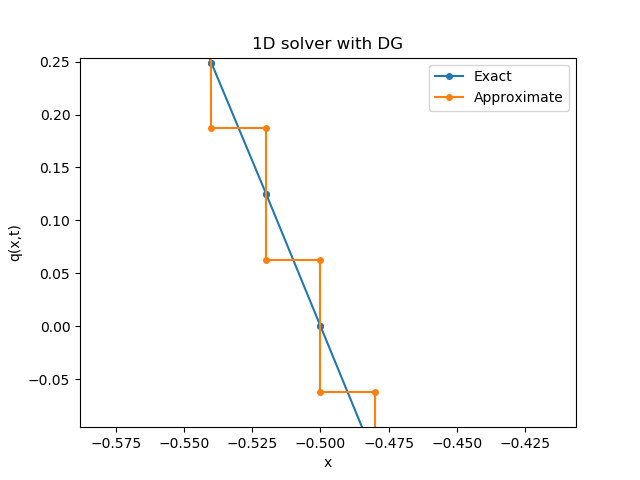

In [32]:
figure(1)
qex = qinit(x-u*t[Nt])
plot(x,qex, '.-',markersize=8, label='Exact')
plot(x,q, '.-', markersize=8, label = 'Approximate')
title('1D solver with DG')
xlabel('x')
ylabel('q(x,t)')
legend()
show()

<IPython.core.display.Javascript object>


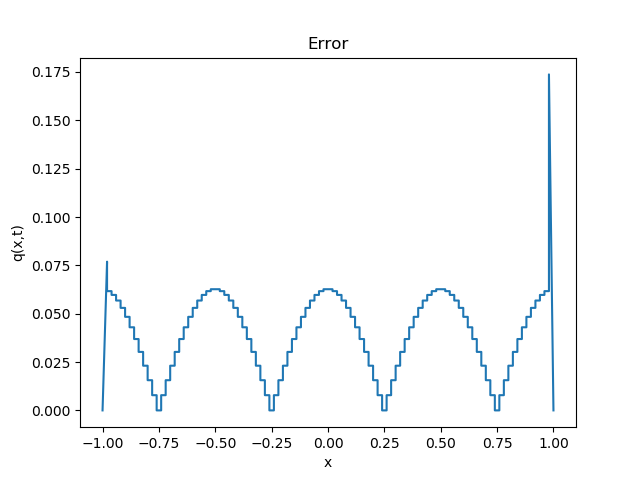

In [26]:
figure(3)
er = abs(q-qex)
plot(x,er)
title('Error')
xlabel('x')
ylabel('q(x,t)')
#legend()
show()